# Can we see the effects of COVID-19 in weather observations?

## Background
Reductions in mobility and economic activity associated with the Coronavirus (COVID-19) pandemic have resulted in unprecedented reductions globally in air pollution (Cohan, 2020; He et al., 2020; NASA, 2020). These reductions are evident in measurements of air pollutants, including particulate matter (PM) and greenhouse gases (GHGs), which contribute to smog and haze and may also affect attributes of climate such as temperatures (via cloud/smog cover) and potentially even precipitation regimes (through cloud seeding processes). While various contemporary data sources are being used to quantify these outcomes (e.g., satellite data, in situ air quality monitoring), a relatively simple dataset that might be used to frame air pollution effects in a longer-term historical context might be the long-term meteorological data provided in the Global Historical Climatology Network (Menne et al., 2012), which include observations of smoke and haze conditions, and climate variables such as temperature and precipitation, across the world and at uniquely long time scales.

<p>  
<figure>
    <img src="https://eoimages.gsfc.nasa.gov/images/imagerecords/146000/146362/china_trop_2020056.png" alt="NASA NO2 over China" width="450"/>
    <figcaption>Fig.1 - Sattelite observations clearly show a reduction in of the air pollutant nitrous dioxide over China when lockdown measures were taken to reduce the spread of the coronavirus (from NASA, 2020).</figcaption>
</figure>
</p>

## Research question
We will test the hypothesis that policies in response to COVID-19 had a significant impact on manual, subjective air quality observations in the United States in 2020, when compared to the historical record.
In particular, we want to answer the question whether the fraction of stations that observed smoke or haze (variable WT08) in the GHCN-D data during the period of January to April 2020 reside within a long-term historical “normal” range of variability?

## Experimental setup and methods

### Computing
We are using [spark-notebook](https://github.com/mas-dse/spark-notebook) with [aws-jupyter](https://github.com/arapat/aws-jupyter) to run our analysis in the cloud.

### Data
We used weather station data from NOAA’s Global Historical Climatology Network Daily (GHCND) data set at ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/. The data is also available on S3 at s3://noaa-ghcn-pds/csv/. We used the variable **WT08**, which provides manual observations of whether smoke and haze were present on a given day. It takes a value of 1 if smoke or haze was observed and a value of 0 if not.

Since the data used for DSC291 in class has not been updated in the last few years, we accessed the data directly from the open data bucket on S3 and transformed it into parquet format, structured in the same way as the data that was pre-processed for class. To get the data into the desired format, we took the following steps: 
1. Read all CSV files from s3://noaa-ghcn-pds/csv/ into one Spark dataframe
2. Translate the dataframe into RDD of rows
3. Map into key-value RDD with the format `key=(Station,year, measurement)  value=[(day-of-year, value)]`
4. Reduce by key: take the union, which results in an RDD of the form: `key=(Station, Year, Measurement) value=[(day-of-year, value),(...), ... ]`
5. Translate the RDD into a dataframe: map the value list into an array of length 365, where Feb 29 is removed for leap years

In [1]:
from Startup import *
from getMostRecentGHCND import getGHCNDdataParquet
#getGHCNDdataParquet(S3fileName='s3://philipp-ghcnd/GHCNDby_year.parquet')

finished standard imports
dict_items([('spark.executor.cores', '1'), ('spark.executor.memory', '3g'), ('spark.logConf', 'True'), ('spark.default.parallelism', '10'), ('spark.app.name', 'Weather_PCA'), ('spark.cores.max', '4')])
started SparkContext and SQLContext in 13.12 seconds
loaded weather.parquet in 7.18 seconds
loaded stations.parquet in 0.17 seconds
registered dataframes as tables in 0.25 seconds


### Experimental design
Summary: perform a set of statistical analyses using GHCN observations of different variables that compare 2020 values to historical values in different exploratory ways.

1. Extract daily values of variables over January - April of all years to the present worldwide.
2. Quantify historic variability in each variable at a site-by-site level: e.g., mean and CI (parametric or non-parametric quantile intervals) by site over all years to 2019. Some data was washed off based on scarcity and availability. 
3. Evaluate placement of 2020 observations relative to long-term variability using p-values of a one-tailed Z-test.

### Methods

In [2]:
from hw3team2 import *
%matplotlib inline

#### Analysis of the GHCN daily WT08 data since 1960 for the US
Since there seemed to be insufficient data coverage with respect to the smoke/haze observations before 1960, we decided to limit our analysis to the years after 1960. Furthermore, the vast majority of weather stations reporting WT08 were situated in the United States, so we are only considering data from the US here. 

In [3]:
qry = """SELECT * FROM parquet.`s3://philipp-ghcnd/GHCNDby_year.parquet`
WHERE SUBSTRING(Station, 1, 2)='US' AND Year>1959 AND Measurement='WT08'"""
df = sqlContext.sql(qry)
pdf = df.toPandas()

To get an idea of the data, we initially plotted the fraction of stations reporting smoke or haze for every day in 2020 so far (up to May 14), together with the means and standard deviations of the corresponding values for all preceding years (upper panel in the figure below). For each day of the year up to May 14, we also ran a one tailed Z-test to test for the hypothesis that the historical mean of the fraction of stations that observed smoke or haze is greater than the corresponding value observed in 2020. 

These plots suggest that the likelihood of observing smog was at least somewhat lower than during the preceding 60 years. However, the color scheme in the upper panel also suggests that the overall likelihood of observing smog has been decreasing over these past 60 years, and that the observed values for 2020 seem to be following the distribution of recent years (orange to red thin lines) more closely. 

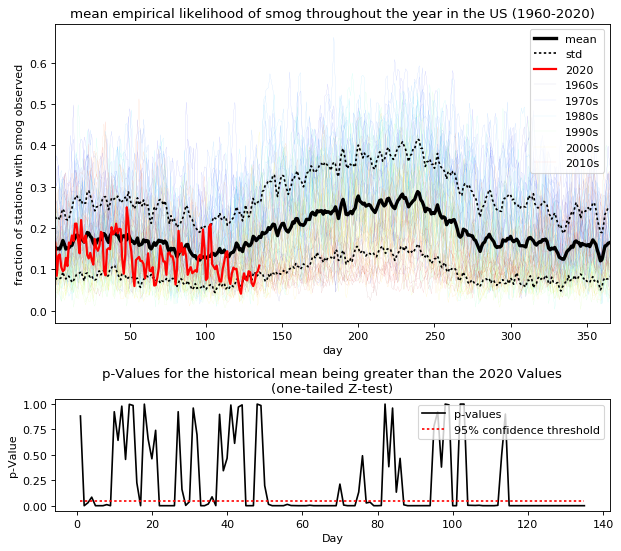

In [4]:
wt08 = ghcnd(pdf)
getYearlyStats(wt08)
plotMeanDaysOfYear(wt08)

Thus we decided to investigate whether there is a decreasing trend in overall smog observations throughout the historical period. To this end, we plotted the fraction of stations that observed smog, averaged across all days from Jan 1 to May 14 for each year since 1960 and fitted a trendline (see figure below). While there seems to be an overall decrease in the frequency of smoggy days, there seems to be an anomalously large sudden increase after 2005 followed by a sharp decrease around 2012. Some [further](https://www.foxnews.com/science/distorted-data-feds-close-600-weather-stations-amid-criticism-theyre-situated-to-report-warmin) [research](https://www.skepticalscience.com/Why-are-there-less-weather-stations-and-whats-the-effect.html) revealed that [NOAA started to build new weather stations around 2005](https://www.gao.gov/new.items/d11800.pdf) but kept the out-dated weather stations operational in an effort to provide continuous time series. However, since late 2012 and mid 2013 most out-dated weather stations have barely been producing any useful data. 

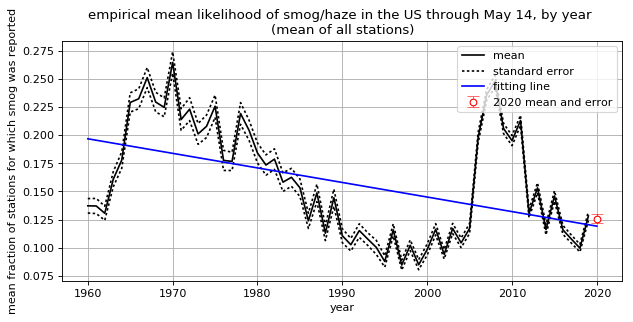

In [5]:
plotMeanByYear(wt08)

#### Limiting the analysis to the last eight years
Since the anomalously high values of smog around 2005-2012 were likely a result of the addition of many new stations and subsequent removal of old weather stations, it does not make much sense to compare this year's observations to any observations made before 2012. Hence, we decided to re-run our analysis for only the last eight years. 

In [6]:
qry = """SELECT * FROM parquet.`s3://philipp-ghcnd/GHCNDby_year.parquet`
WHERE SUBSTRING(Station, 1, 2)='US' AND Year>2011 AND Measurement='WT08'"""
df = sqlContext.sql(qry)
pdf = df.toPandas()
wt08_recent = ghcnd(pdf)
getYearlyStats(wt08_recent)

We now see that the data for 2020 follows the pattern of the previous few years, and the likelihood of observing smog in 2020 was not significantly lower than in the preceding years. 

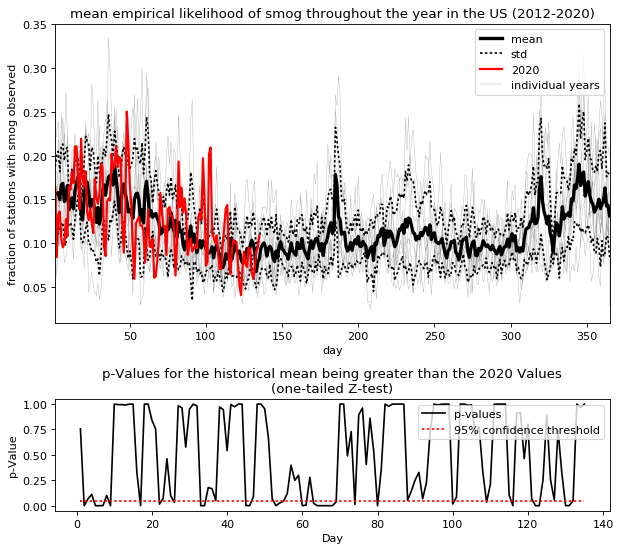

In [7]:
plotMeanDaysOfYear(wt08_recent)

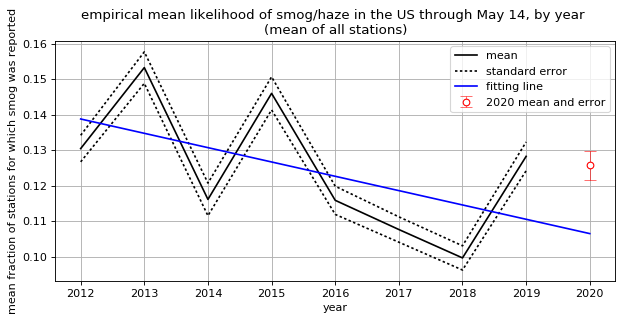

In [8]:
plotMeanByYear(wt08_recent)

## Results
We could not see any statistically significant effects of COVID-19 in the smoke/haze observations in the GHCN daily data set.

## References

- He, G., Pan, Y., & Tanaka, T. (2020). COVID-19, City Lockdowns, and Air Pollution: Evidence from China. medRxiv. (about 25% increase in Air Quality Index AQI
- Menne, M. J., Durre, I., Vose, R. S., Gleason, B. E., & Houston, T. G. (2012). An overview of the global historical climatology network-daily database. Journal of atmospheric and oceanic technology, 29(7), 897-910.
- NASA . 2020. Airborne Nitrogen Dioxide Plummets over China. Url: https://earthobservatory.nasa.gov/images/146362/airborne-nitrogen-dioxide-plummets-over-china
- Cohan, D., (2020). COVID-19 shutdowns are clearing the air, but pollution will return as economies reopen. The conversation. Url: https://theconversation.com/covid-19-shutdowns-are-clearing-the-air-but-pollution-will-return-as-economies-reopen-134610

## Work contributions
All team members contributed equally for this homework (~30 hours per person).